## 4 - Brightness Analysis
## Table of Contents
<ul>
<li><a href="#1">Crop, Mask, Threshold and Median</a></li>
<li><a href="#2">Calculate Median Brightness of Segments</a></li>
<li><a href="#3">Calculate Brightness of Fractures</a></li>
<li><a href="#4">Histogram of Segment Count vs Brightness</a></li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
df_segments = pd.read_csv("./output/df_segments_2.csv")

df_segments.head()

,fracture_id,segment_id,X1,Y1,X2,Y2,delta_X,delta_Y,segment_size,angle_radian,angle_degree
0,1528,1528_2,14880.257,8797.5608,14890.307,8777.9108,10.050,-19.6500,22.070908,2.043562,117.087491
1,1528,1528_1,14872.006,8806.2608,14880.257,8797.5608,8.251,-8.7000,11.990371,2.329713,133.482698
2,1527,1527_4,20349.119,3322.3508,20357.025,3323.7462,7.906,1.3954,8.028199,0.174700,10.009551
3,1527,1527_3,20350.282,3311.8852,20349.119,3322.3508,-1.163,10.4656,10.530021,1.681468,96.341033
4,1527,1527_2,20338.188,3311.4201,20350.282,3311.8852,12.094,0.4651,12.102940,0.038438,2.202343


In [3]:
# Reading the image grayscale
image = cv2.imread('Global_20190321_ShapeV20_200kfacets_FB3.png', cv2.IMREAD_GRAYSCALE)

image = cv2.flip(image, 0)

<a id='1'></a>
## Crop, Mask, Threshold and Median

In [4]:
df_segments["median_brightness"] = None

In [5]:
def crop_mask_median(index, plot = False, remove_shadow = False, threshold = 40):

    X1, X2, Y1, Y2 = int(df_segments['X1'][index]), int(df_segments['X2'][index]), int(
        df_segments['Y1'][index]), int(df_segments['Y2'][index])

    center_coordinates = (int((X1+X2)/2), int((Y1+Y2)/2))
    x, y = center_coordinates[0], center_coordinates[1]

    radius = int(df_segments['segment_size'][index]/2)

    # if the segment size is too small (less than 1 pixel, round it to 1) there are only 11 segments like that so it will not impact the result
    if radius < 1:
        radius = 1

    cropped_image = np.zeros((radius*2, radius*2), np.uint8)
    
    # crop the image
    cropped_image = image[(y-radius):(y+radius), (x-radius):(x+radius)]

    # create mask
    mask = np.zeros((radius*2, radius*2), np.uint8)
    cv2.circle(mask, (radius, radius), radius, radius, -1)

    # apply mask
    masked = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)

    # converting the mask values to boolean values
    mask_bool = mask.astype(bool)

    # index mask with these boolean values to extract only the pixels under the mask, save it into an array
    masked_pixels = cropped_image[mask_bool]
    
    #print("Before thresholding")
    #print("mean:", masked_pixels.mean())
    #print("median:", np.median(masked_pixels))

    # apply thresholding to remove the shadows, if remove_shadow is True
    masked_unshadowed = np.copy(masked)
    if remove_shadow == True:
        
        masked_unshadowed[masked_unshadowed < threshold] = 225
        masked_pixels = masked_pixels[masked_pixels > threshold]

        #print("After thresholding")
        #print("mean:", masked_pixels.mean())
        #print("median:", np.median(masked_pixels))

        if masked_pixels.size == 0:
            masked_pixels = threshold

    # calculate median value
    median_value = np.median(masked_pixels)

    # rest of the code is for plotting the figures
    if plot == True:    
        # create figure
        fig = plt.figure(figsize=(10, 7))   
        # setting values to rows and column for subplots
        rows = 2
        columns = 2 
        fig.add_subplot(rows, columns, 1)   
        plt.imshow(cropped_image, cmap="gray")
        plt.axis('off')
        plt.title("Cropped Image")  
        fig.add_subplot(rows, columns, 2)   
        plt.imshow(mask, cmap="gray")
        plt.axis('off')
        plt.title("Mask")   
        fig.add_subplot(rows, columns, 3)   
        plt.imshow(masked, cmap="gray")
        plt.axis('off')
        plt.title("Masked") 
        if remove_shadow == True:
            fig.add_subplot(rows, columns, 4)
            plt.imshow(masked_unshadowed, cmap="gray")
            plt.axis('off')
            plt.title("Thresholding to Remove Shadow")  
        plt.show()  
    return median_value

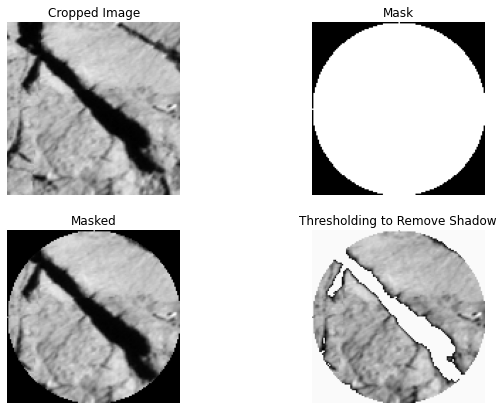

165.0

In [6]:
crop_mask_median(3243, plot = True, remove_shadow = True, threshold = 40)

The idea here is to draw a circle that will surround the segment (the segment will be the diameter of the circle) and calculate the median brightness of the pixels that are inside the circle.
Above function will:
<ol type="1">
    <li>Crops the square area from the original image that circumscribes the circle</li>
    <li>Creates a mask which will be same size with the cropped image, draw the cricle</li>
    <li>Apply bitwise AND between the cropped image and mask (This is to display how the masked image will look like)</li>
    <li>Convert the mask to a boolean mask and index the cropped image with the boolean mask, save it to an array. So that we will only store the pixels values under the mask (ROI)</li>
    <li>Apply np.median() function to calculate the median value of all the pixels under the mask, which will tell us the median brigtness of ROI</li>
</ol> 

<a id='2'></a>
## Calculate Median Brightness of Segments

In [7]:
# Iterate over the dataframe to apply the function for each row (segment) save it into the new column named 'median_brightness'
from cv2 import threshold

for index, row in df_segments.iterrows():
    median_value = crop_mask_median(index, plot = False, remove_shadow = True, threshold = 40)
    
    df_segments.loc[index, "median_brightness"] = median_value

df_segments.head()

,fracture_id,segment_id,X1,Y1,X2,Y2,delta_X,delta_Y,segment_size,angle_radian,angle_degree,median_brightness
0,1528,1528_2,14880.257,8797.5608,14890.307,8777.9108,10.050,-19.6500,22.070908,2.043562,117.087491,155.0
1,1528,1528_1,14872.006,8806.2608,14880.257,8797.5608,8.251,-8.7000,11.990371,2.329713,133.482698,94.0
2,1527,1527_4,20349.119,3322.3508,20357.025,3323.7462,7.906,1.3954,8.028199,0.174700,10.009551,196.0
3,1527,1527_3,20350.282,3311.8852,20349.119,3322.3508,-1.163,10.4656,10.530021,1.681468,96.341033,182.0
4,1527,1527_2,20338.188,3311.4201,20350.282,3311.8852,12.094,0.4651,12.102940,0.038438,2.202343,212.0


In [8]:
# save dataframe to csv
df_segments.to_csv('./output/df_segments_3.csv', index=False)

In [9]:
image = cv2.imread('Global_20190321_ShapeV20_200kfacets_FB3.png')
image = cv2.flip(image, 0)

In [10]:
# Draw lines, circles and brightness labels
for index, row in df_segments.iterrows():

    X1, Y1, X2, Y2 = int(row['X1']), int(
        row['Y1']), int(row['X2']), int(row['Y2'])

    start_point = (X1, Y1)
    end_point = (X2, Y2)

    # Green color in BGR
    line_color = (0, 255, 0)

    # Blue color in BGR
    circle_color = (255, 0, 0)

    # Line thickness
    thickness = 1

    center_coordinates = (int((X1+X2)/2), int((Y1+Y2)/2))

    radius = int(df_segments['segment_size'][index]/2)

    # draw the lines
    image = cv2.line(image, start_point, end_point, line_color, thickness)

    # draw the circles
    image = cv2.circle(image, center_coordinates, radius, circle_color, thickness)

    median_brightness = str(int(row['median_brightness']))

    label_brightness = np.zeros((11, 24, 3), np.uint8)
    # White color in BGR
    text_color = (255, 255, 255)
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # fontScale
    fontScale = 0.4
    # Using cv2.putText() method
    label_brightness = cv2.putText(
        label_brightness, median_brightness, (0, 9), font, fontScale, text_color)

    label_brightness = cv2.flip(label_brightness, 0)

    x, y = center_coordinates[0], center_coordinates[1]
    h, w = label_brightness.shape[:2]
    image[y:y+h, x:x+w] = label_brightness

image = cv2.flip(image, 0)

cv2.imwrite('./output/bennu_brightness.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 100])

True

### Samples from the Output
<img src="in_cell_images/median1.png">
<img src="in_cell_images/median2.png">

<a id='3'></a>
## Calculate Brightness of Fractures

As we now have the median brightness of each indivulal segment that composes a fracture, we can now calculate the avarage brightness of each fracture.

We will calculate a weighted (based on the size of segment) avarage brightness and update the df_fractures.

In [11]:
df_fractures = pd.read_csv("./output/df_fractures_3.csv")

In [12]:
for index, row in df_fractures.iterrows():
    fracture_id = row['fracture_id']

    total_size = df_segments[df_segments.fracture_id ==
                             fracture_id].segment_size.sum()

    # just to fix one fracture (false annotation)
    if total_size < 1:
        total_size = 1

    total_weighted = 0
    for index, row in df_segments[df_segments.fracture_id == fracture_id].iterrows():
        weighted = row['segment_size']*row['median_brightness']
        total_weighted += weighted

    weighted_average_brightness = total_weighted/total_size

    df_fractures.loc[df_fractures.fracture_id == fracture_id,
                     'w_average_brightness'] = weighted_average_brightness


In [13]:
df_fractures.head()

,fracture_id,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction,total_size,w_average_angle_degree,w_average_brightness
0,0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",yellow,3,2704.0042,2799.9979,2726.5764,2886.5779,160.0015,95.9937,Vertical,194.911960,59.174355,164.262832
1,1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",blue,3,2755.0029,2857.0003,2736.5771,2830.5703,93.9932,101.9974,Horizontal,149.359400,43.338584,155.376969
2,2,"2612.9964,2824.5755,2708.7733,2805.8089",blue,3,2612.9964,2708.7733,2805.8089,2824.5755,18.7666,95.7769,Horizontal,97.598155,168.913872,152.000000
3,3,"2655.0037,2794.5735,2613.9955,2756.5784",blue,3,2613.9955,2655.0037,2756.5784,2794.5735,37.9951,41.0082,Horizontal,55.904383,42.815860,160.000000
4,4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",blue,3,3004.4430,3121.4356,2762.0149,2778.0103,15.9954,116.9926,Horizontal,118.111506,7.785202,171.300731


In [14]:
# save dataframe to csv
df_fractures.to_csv('./output/df_fractures_4.csv', index=False)

<a id='4'></a>
## Histogram of Segment Count vs Brightness

In [15]:
number_of_bins = 20

In [16]:
bin_edges_brightness = np.linspace(0, 255, number_of_bins+1)

bin_edges_brightness

array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
       102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
       204.  , 216.75, 229.5 , 242.25, 255.  ])

### Histogram Values

In [17]:
pd.cut(x=df_segments['median_brightness'], bins=bin_edges_brightness).value_counts().sort_index()

(0.0, 12.75]         0
(12.75, 25.5]        0
(25.5, 38.25]        0
(38.25, 51.0]        2
(51.0, 63.75]        2
(63.75, 76.5]        8
(76.5, 89.25]       19
(89.25, 102.0]      70
(102.0, 114.75]    159
(114.75, 127.5]    281
(127.5, 140.25]    371
(140.25, 153.0]    410
(153.0, 165.75]    382
(165.75, 178.5]    353
(178.5, 191.25]    342
(191.25, 204.0]    320
(204.0, 216.75]    233
(216.75, 229.5]    163
(229.5, 242.25]     85
(242.25, 255.0]     44
Name: median_brightness, dtype: int64

### Bar Histogram

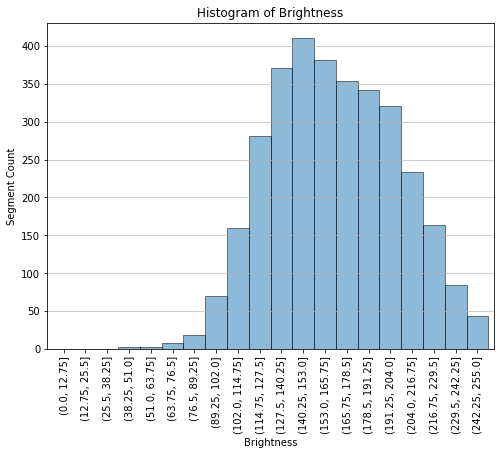

In [18]:
plt.figure(figsize=(8, 6))

ax = pd.cut(x=df_segments['median_brightness'], bins=bin_edges_brightness).value_counts().sort_index().plot(kind='bar', width=1.0, alpha=0.5, ec='black')

plt.grid(axis='y', alpha=0.75)

# set chart title
ax.set_title('Histogram of Brightness')
# set x, y axes labels
ax.set_xlabel("Brightness")
ax.set_ylabel("Segment Count")

plt.show()